# Predicting a Film's Success

### Utilizing Gradient Boosted Trees

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from time import time

## Set Up

We're going to use two datasets:

1. TMDB Top 10,000 Most Popular Movies [source](https://www.kaggle.com/datasets/balaka18/tmdb-top-10000-popular-movies-dataset)
2. Highest Grossing Movies (as of 10th Jan 2022) [source](https://www.kaggle.com/datasets/sanjeetsinghnaik/top-1000-highest-grossing-movies)

We use the first dataset as our main training and testing resources with the second dataset to label whether films from the first dataset is successful or not.

In [2]:
tmdb = pd.read_csv("tmdb_10000_movies_data.csv")

In [3]:
hgmb = pd.read_csv("highest_grossing_movies.csv")

hgmb.drop(['Unnamed: 0', 'Movie Info', 'Movie Runtime'], axis = 1, inplace = True)
strip_year = lambda x : x.split("(")[0].strip()

hgmb['Year'] = hgmb['Title'].apply(lambda title : title[-5:-1])
hgmb['Title'] = hgmb['Title'].apply(lambda title : strip_year(title))

hgmb.sort_values(by = ['World Sales (in $)'], ascending = False, inplace = True)
hgmb.reset_index(drop = True, inplace = True)

## EDA and Data Preprocessing

We have a lot of features that we need to preprocess here, but before that, we need to know and discern the problems in our dataset. 

First, we need to drop irrelevant columns to make our EDA so much easier.

In [4]:
tmdb.drop(['TMDb_Id', 'IMDb_Id', 'Original_Title', 'Cast', 'Crew', 'Release_Date', 'Original_Language', 'Genres', 'Overview', 'Release_Status', 'Country_of_Origin', 'Languages_Spoken', 'Tagline'], axis = 1, inplace = True)

In [6]:
tmdb.head()

,Title,Collection,Runtime,Popularity,Rating_average,Rating_Count,Production_Companies,Budget,Revenue
0,Ad Astra,Single,123.0,463.487,5.9,2863,New Regency Productions | Keep Your Head | Mad...,87500000.0,127175922.0
1,Bloodshot,Single,110.0,235.701,7.2,1384,Sony Pictures | Cross Creek Pictures | Mimran ...,42000000.0,24573617.0
2,Bad Boys for Life,Bad Boys Collection,124.0,255.068,7.1,2596,Columbia Pictures | Platinum Dunes | 2.0 Enter...,0.0,191150000.0
3,Ant-Man,Ant-Man Collection,117.0,134.294,7.1,13625,Marvel Studios,130000000.0,519311965.0
4,Percy Jackson: Sea of Monsters,Percy Jackson Collection,106.0,124.417,5.9,3547,Fox 2000 Pictures | Sunswept Entertainment | 1...,90000000.0,199850315.0


In [7]:
tmdb.shape

(10000, 9)

In [8]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Title                 10000 non-null  object 
 1   Collection            9999 non-null   object 
 2   Runtime               9986 non-null   float64
 3   Popularity            10000 non-null  float64
 4   Rating_average        10000 non-null  float64
 5   Rating_Count          10000 non-null  int64  
 6   Production_Companies  9697 non-null   object 
 7   Budget                9999 non-null   float64
 8   Revenue               9999 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 703.2+ KB


Now we notice that there are columns with non-existent values, for now, we can just remove and clean these observations from our dataset. 

In [9]:
tmdb.dropna(subset=['Collection', 'Runtime', 'Production_Companies', 'Budget', 'Revenue'], inplace=True)

Counting the amount of zeroes in our numerical columns and removing them. There are other ways to handle and preprocess this issue, but complex methods like imputation may not be suitable for this problem as the missing data makes up a significant portion of the whole dataset, and it may remove the integrity and unbiasedness of the model's prediction.

In [10]:
tmdb.eq(0).sum()

Title                      0
Collection                 0
Runtime                  140
Popularity                 0
Rating_average           159
Rating_Count             159
Production_Companies       0
Budget                  3923
Revenue                 3945
dtype: int64

In [12]:
tmdb = tmdb[(tmdb['Revenue'] != 0) & (tmdb['Budget'] != 0)]

In [13]:
tmdb.eq(0).sum()

Title                   0
Collection              0
Runtime                 0
Popularity              0
Rating_average          0
Rating_Count            0
Production_Companies    0
Budget                  0
Revenue                 0
dtype: int64

In [14]:
tmdb_num = tmdb.select_dtypes(include=[int, float])
tmdb_cat = tmdb.select_dtypes(include=['category', 'object'])

### Numerical Analysis

Onto the numerical analysis, here, we explore the distribution and central tendency of our numerical features.

In [15]:
tmdb.describe()

,Runtime,Popularity,Rating_average,Rating_Count,Budget,Revenue
count,4771.000000,4771.000000,4771.000000,4771.000000,4.771000e+03,4.771000e+03
mean,110.511842,15.378307,6.514337,1828.896458,3.689554e+07,1.126694e+08
std,20.844649,12.321273,0.842906,2628.145588,4.345517e+07,1.918481e+08
min,26.000000,4.905000,2.600000,4.000000,1.000000e+00,5.000000e+00
25%,96.000000,10.764000,6.000000,360.500000,9.000000e+06,1.500000e+07
50%,107.000000,12.696000,6.500000,852.000000,2.200000e+07,4.644253e+07
75%,121.000000,16.238500,7.100000,2109.000000,4.900000e+07,1.247794e+08
max,248.000000,463.487000,8.800000,25159.000000,3.800000e+08,2.797801e+09


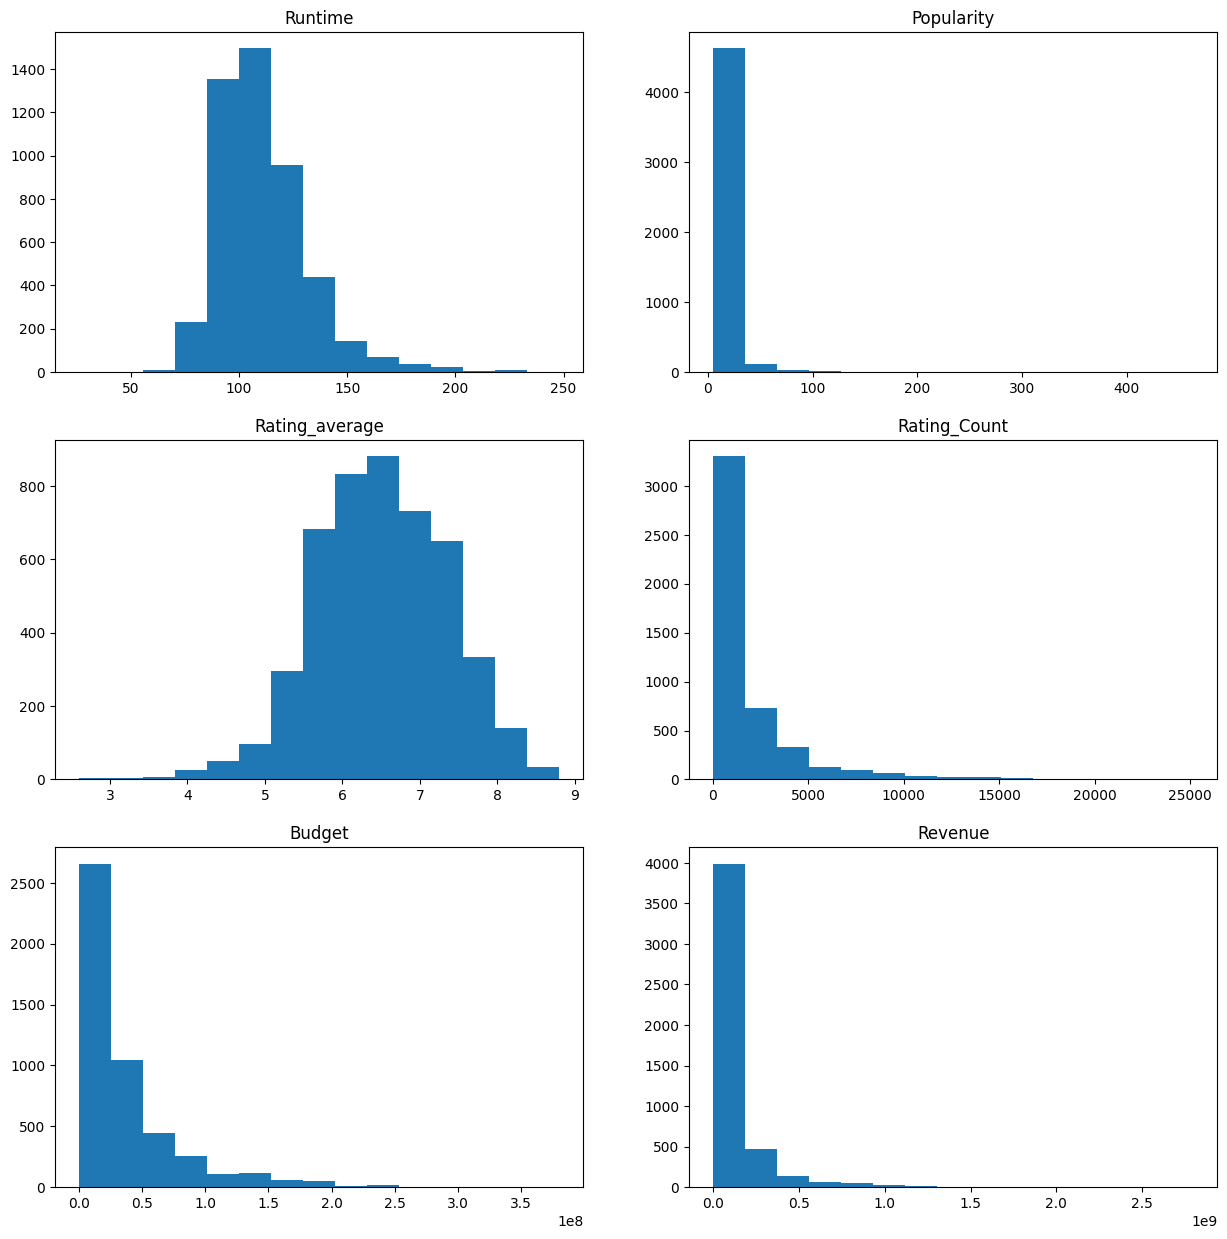

In [24]:
def plot_dist(df, row, col, size):
    fig, ax = plt.subplots(row, col, figsize=size)

    ax = ax.ravel()
    for i, a in enumerate(ax):
        a.hist(df.iloc[:, i], bins=15)
        a.set_title(df.columns[i])
        
plot_dist(tmdb_num, 3, 2, (15, 15))

### Log Transformation

We can see that some of our important numerical features are skewed to the right, namely **Budget, Popularity, and Rating**
Then, we're going to use **Log Transformation** to scale the magnitude of these features and to reduce the impact of extreme values.

In [18]:
scaled_features = ['Popularity', 'Rating_Count', 'Budget']

log_transformed_tmdb = np.log1p(tmdb[scaled_features])

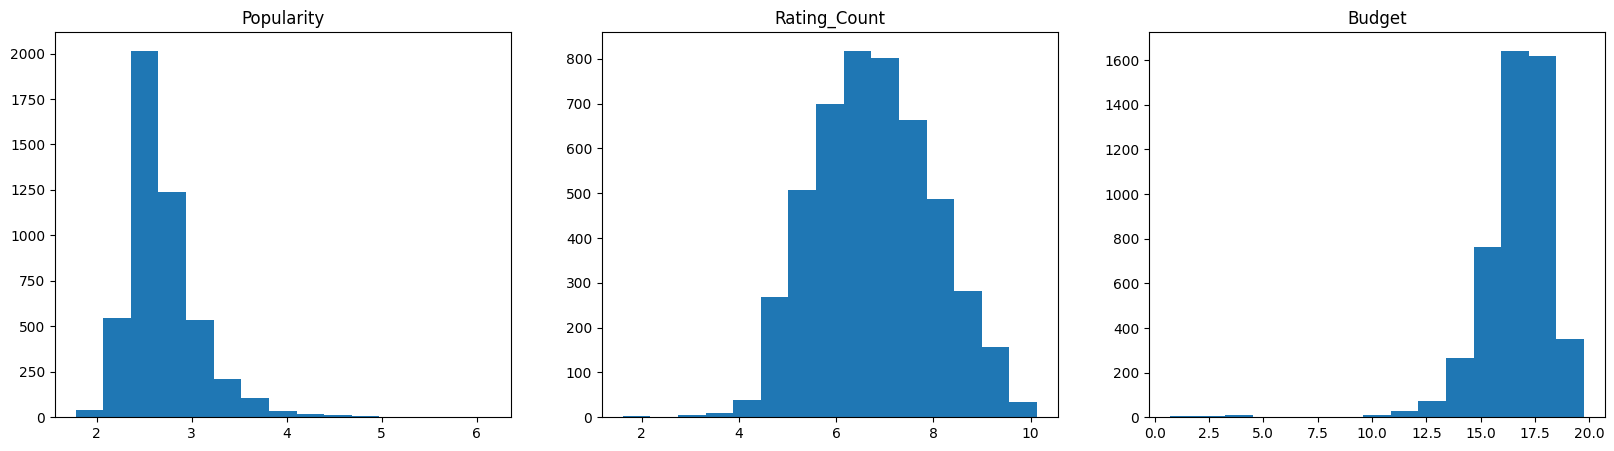

In [25]:
plot_dist(log_transformed_tmdb, 1, 3, (20, 5))

In [26]:
tmdb.drop(columns=scaled_features, inplace=True)
tmdb = pd.concat([tmdb, log_transformed_tmdb], axis=1)

### Normalization

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

tmdb[tmdb_num.columns] = scaler.fit_transform(tmdb[tmdb_num.columns])
tmdb.describe()

,Runtime,Rating_average,Revenue,Popularity,Rating_Count,Budget
count,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000,4771.000000
mean,0.380684,0.631345,0.040271,0.211463,0.607887,0.837980
std,0.093895,0.135953,0.068571,0.087184,0.142482,0.086580
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.315315,0.548387,0.005361,0.157898,0.502233,0.803649
50%,0.364865,0.629032,0.016600,0.192733,0.602954,0.850538
75%,0.427928,0.725806,0.044599,0.245432,0.709210,0.892546
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Categorical Features Handling

**Collection**

Collection explains whether a movie is a part of an ongoing franchise / trilogy / saga / series. We suspect if a film is produced to be a part of a greater franchise, it'll make more money since there's either financial or critical receptions buzzing around the movie.

In [31]:
tmdb['Collection'] = tmdb['Collection'].apply(lambda val: 0 if val == 'Single' else 1)

**Production Companies**

We all know that production companies play a huge role in filmmaking, from resources and budget to marketing strategies, getting your film funded by the film giants is one of the most important aspects in getting your film's popularity to the roof.

In [32]:
major_prod_comps = set(['Sony Pictures', 'Warner Bros', 'Disney', 'Columbia',
                          'Universal Pictures', 'Paramount', 'New Line', '20th Century',
                          'Metro-Goldwyn-Mayer', 'Lionsgate', 'DreamWorks', 'Marvel'])

for comp in major_prod_comps:
    amnt = len(tmdb[tmdb['Production_Companies'].str.contains(comp, regex=True)])
    print(f'Amount of movies produced by {comp}: {amnt}')

Amount of movies produced by Columbia: 339
Amount of movies produced by Paramount: 359
Amount of movies produced by Universal Pictures: 417
Amount of movies produced by 20th Century: 307
Amount of movies produced by Lionsgate: 89
Amount of movies produced by Sony Pictures: 131
Amount of movies produced by Disney: 180
Amount of movies produced by DreamWorks: 129
Amount of movies produced by New Line: 181
Amount of movies produced by Warner Bros: 456
Amount of movies produced by Metro-Goldwyn-Mayer: 139
Amount of movies produced by Marvel: 50


In [36]:
def does_contain(s, comps):
    for comp in comps:
        if re.search(comp, s):
            return 1
    return 0

tmdb['Big_Production_Company'] = tmdb['Production_Companies'].apply(lambda val: does_contain(val, major_prod_comps))

**Successful (Target Variable)**

We're going to label whether a film is successful or not with the logic: <br>
*If a movie is in the top 1000 highest grossing, then we set **success** as 1, else 0*

In [37]:
successful_titles = set(hgmb['Title'])

tmdb['Successful'] = tmdb['Title'].apply(lambda title: 1 if title in successful_titles else 0)

In [38]:
tmdb_successful = tmdb[tmdb['Successful'] == 1]

print(f'Amount of parsed successful titles: {len(tmdb_successful)}')
print(f'Amount of total successful titles: {len(successful_titles)}')

Amount of parsed successful titles: 866
Amount of total successful titles: 911


### Final DataFrame

Dropping columns that are no-longer used. Revenue is removed because we already label each film with the success column

In [43]:
df = tmdb.drop(columns=['Title', 'Production_Companies', 'Revenue'])

In [44]:
df.head()

,Collection,Runtime,Rating_average,Popularity,Rating_Count,Budget,Big_Production_Company,Successful
0,0,0.436937,0.532258,1.000000,0.745056,0.922962,0,0
1,0,0.378378,0.741935,0.845564,0.659819,0.884459,1,0
3,1,0.409910,0.725806,0.717424,0.928049,0.943731,1,1
4,1,0.360360,0.532258,0.700057,0.770182,0.924440,1,0
5,0,0.373874,0.725806,0.799495,0.737353,0.914876,1,0


In [45]:
target = 'Successful'
features = [col for col in df.columns if col != target]

## Machine Learning Models Experimentation

We're going to experiment with three different supervised machine learning algorithms to test out their performances (Decision Tree, Random Forest, and Gradient Boosted Trees).

In [46]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], train_size=0.8)

In [48]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3816, 7)
(955, 7)
(3816,)
(955,)


We'll use accuracy and area under curve to measure the models' performance.

In [49]:
def train_predict(model, sample_size, X_train, y_train, X_test, y_test): 
    results = {}
    
    # Training
    start = time()
    model = model.fit(X_train[:int(X_train.shape[0]*sample_size)], y_train[:int(X_train.shape[0]*sample_size)])
    end = time()
    results['train_time'] = end - start
    
    # Testing
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train[:300])
    end = time() 
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['auc_train'] = roc_auc_score(y_train[:300], predictions_train)
        
    results['auc_test'] = roc_auc_score(y_test, predictions_test)
       
    print("{} trained on {} samples.".format(model.__class__.__name__, sample_size))
        
    return results

In [56]:
RANDOM_STATE = 42

clf_A = DecisionTreeClassifier(random_state=RANDOM_STATE)
clf_B = RandomForestClassifier(random_state=RANDOM_STATE)
clf_C = GradientBoostingClassifier(random_state=RANDOM_STATE)

In [57]:
samples_100 = len(y_train)
samples_10 = 0.5 * len(y_train)
samples_1 = 0.1 * len(y_train)

In [58]:
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

DecisionTreeClassifier trained on 381.6 samples.
DecisionTreeClassifier trained on 1908.0 samples.
DecisionTreeClassifier trained on 3816 samples.
RandomForestClassifier trained on 381.6 samples.
RandomForestClassifier trained on 1908.0 samples.
RandomForestClassifier trained on 3816 samples.
GradientBoostingClassifier trained on 381.6 samples.
GradientBoostingClassifier trained on 1908.0 samples.
GradientBoostingClassifier trained on 3816 samples.


In [59]:
def evaluation(results):
    import matplotlib.patches as mpatches

    fig, ax = plt.subplots(2, 3, figsize = (11,7))
    bar_width = 0.3
    colors = ['dodgerblue','blue','darkblue']
    
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'auc_train', 'pred_time', 'acc_test', 'auc_test']):
            for i in np.arange(3):
                
                ax[j//3, j%3].bar(i + k * bar_width, results[learner][i][metric], width=bar_width, color=colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("AUC")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("AUC")
    
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("AUC on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("AUC on Testing Set")


    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    plt.tight_layout()

    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.80, 2.53), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    plt.show()

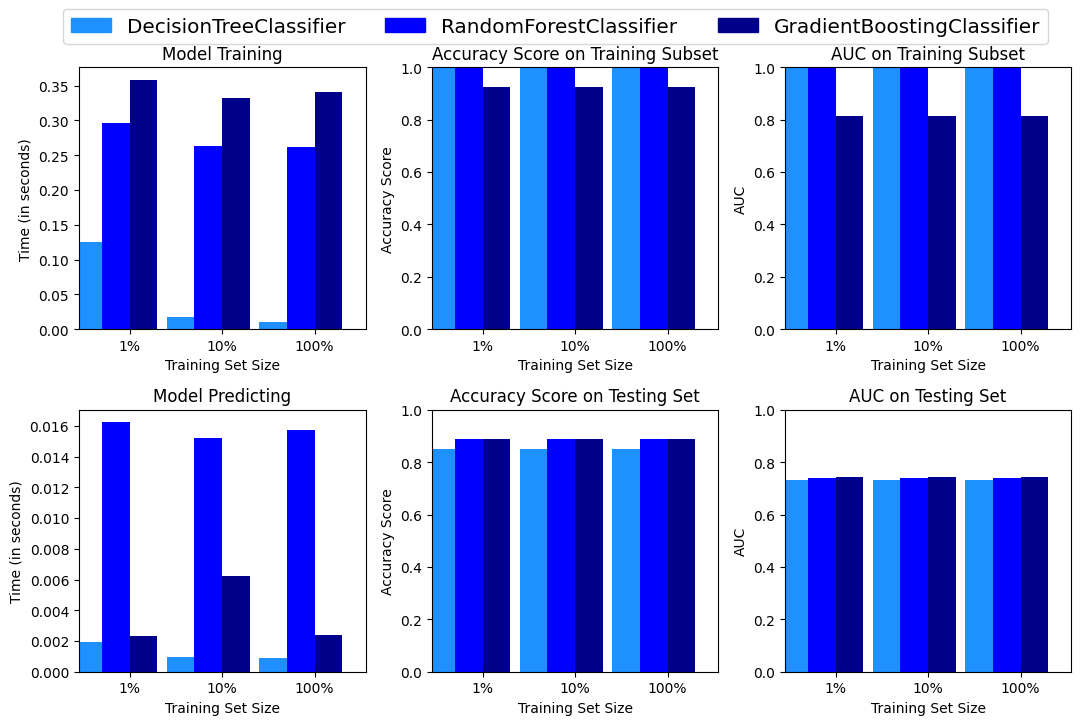

In [60]:
evaluation(results)

From the above evaluation visualization, we can conclude that:

1. Gradient Boosted Trees is the best algorithm in this situation since the other two suffer from overfitting.
2. Despite Decision Tree and Random Forest is fairly pretty quick in terms of their model training, Gradient Boosted Trees is still fairly pretty quick, so time is not the highest priority in this context.

## Hyperparameters Tuning

After choosing Gradient Boosting Trees as the best model, then we can proceed with hyperparameters tuning to get the best estimated parameters to build the final model. We're using GridSearchCV instead of RandomizedSearchCV because our dataset is pretty small.

In [61]:
model_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.1, 0.5, 1],
    'min_impurity_decrease': [0.1, 0.3]
}

clf =  GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE), model_params)

In [62]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [3, 4, 6, 8],
                         'min_impurity_decrease': [0.1, 0.3, 0.5],
                         'n_estimators': [50, 100, 200, 300]})

In [63]:
print(f'Best Score: {clf.best_score_}')
print(f'Best Params: {clf.best_params_}')

Best Score: 0.8875769386480756
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_impurity_decrease': 0.1, 'n_estimators': 100}


In [64]:
best_clf = clf.best_estimator_

In [65]:
acc_best_predictions = best_clf.predict(X_test)
auc_best_predictions = best_clf.predict_proba(X_test)[:, 1]

In [66]:
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, acc_best_predictions)))
print("Final AUC on the testing data: {:.4f}".format(roc_auc_score(y_test, auc_best_predictions)))

Final accuracy score on the testing data: 0.8880
Final AUC on the testing data: 0.9068
